### PHYS3600 Fall 2021, Worksheet 5
#### Jake Postiglione

In [245]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.model_selection import KFold
from sklearn import linear_model  #New!

%matplotlib inline

font = {'size': 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 300
from sklearn.metrics import make_scorer
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate, KFold

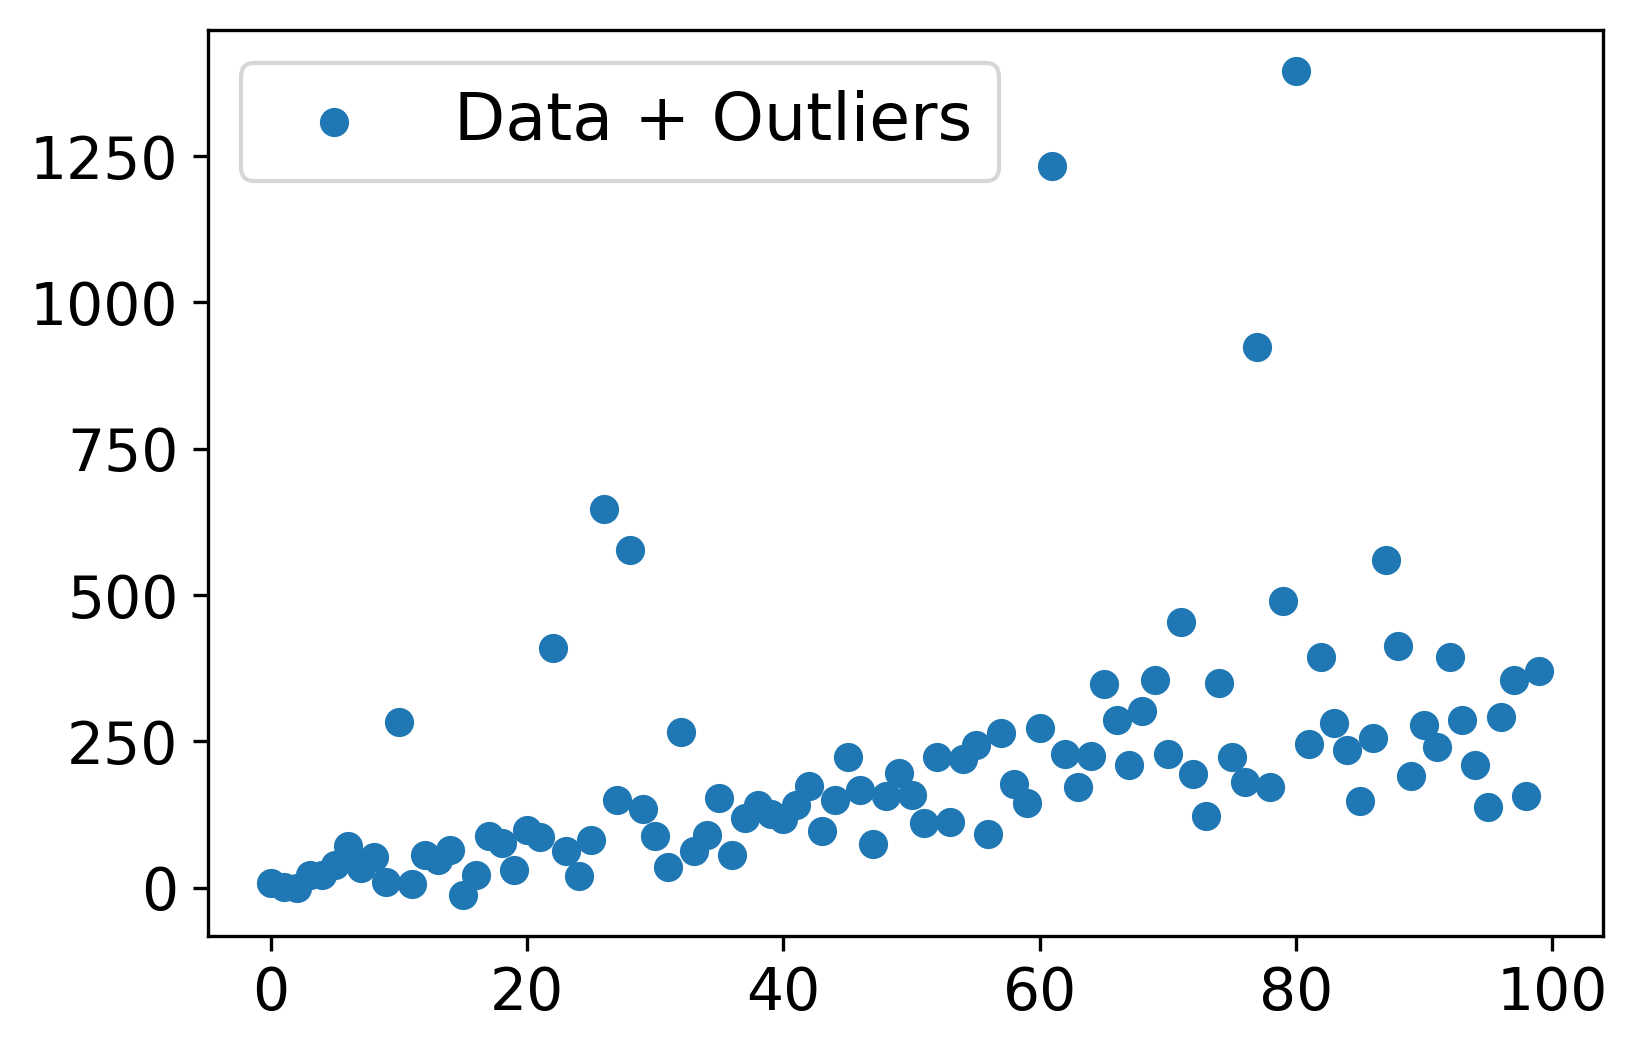

In [246]:
# Generate data with poisson distribution
np.random.seed(18)
x = np.arange(100)
poisson_data = 3 * x + 3 + 5 * (np.random.poisson(3 * x + 3, 100) - (3 * x + 3))

# Generate outlier data and combine with poisson data
np.random.seed(14)
outliers = np.random.choice(100, 15)
poisson_outliers_data = np.copy(poisson_data)
poisson_outliers_data[outliers] = poisson_outliers_data[outliers] + 5 * np.random.rand(15) * poisson_data[outliers]

plt.scatter(x, poisson_outliers_data, label='Data + Outliers')
plt.legend();

In [247]:
theta0 = np.linspace(-5,5,200)
theta1 = np.linspace(-5,5,200)

In [248]:
mean_squared_error = np.empty((200, 200))

for i, t0 in enumerate(theta0):
    for j, t1 in enumerate(theta1):
        mean_squared_error[i, j] = np.sum((t0 + t1 * x - poisson_outliers_data) ** 2) / len(poisson_outliers_data)

mse_unraveled_index = np.unravel_index(mean_squared_error.argmin(), mean_squared_error.shape)

mse_intercept, mse_slope = theta0[mse_unraveled_index[0]], theta1[mse_unraveled_index[1]]

print("Unraveled Index:", mse_unraveled_index)
print("Intercept: ", mse_intercept, "Slope: ", mse_slope)

Unraveled Index: (199, 180)
Intercept:  5.0 Slope:  4.045226130653267


In [249]:
mean_absolute_error = np.empty((200, 200))

for i, t0 in enumerate(theta0):
    for j, t1 in enumerate(theta1):
        mean_absolute_error[i, j] = np.sum(np.abs(t0 + t1 * x - poisson_outliers_data)) / len(poisson_outliers_data)

mae_unraveled_index = np.unravel_index(mean_absolute_error.argmin(), mean_absolute_error.shape)

mae_intercept, mae_slope = theta0[mae_unraveled_index[0]], theta1[mae_unraveled_index[1]]

print("Unraveled Index:", mae_unraveled_index)
print("Intercept: ", mae_intercept, "Slope: ", mae_slope)

Unraveled Index: (199, 163)
Intercept:  5.0 Slope:  3.190954773869347


In [250]:
mean_absolute_percent_error = np.empty((200, 200))

for i, t0 in enumerate(theta0):
    for j, t1 in enumerate(theta1):
        mean_absolute_percent_error[i, j] = np.sum(np.abs(t0 + t1 * x - poisson_outliers_data) / poisson_outliers_data) / len(poisson_outliers_data)

mape_unraveled_index = np.unravel_index(mean_absolute_percent_error.argmin(), mean_absolute_percent_error.shape)

mape_intercept, mape_slope = theta0[mape_unraveled_index[0]], theta1[mape_unraveled_index[1]]

print("Unraveled Index:", mape_unraveled_index)
print("Intercept: ", mape_intercept, "Slope: ", mape_slope)


Unraveled Index: (199, 155)
Intercept:  5.0 Slope:  2.7889447236180906


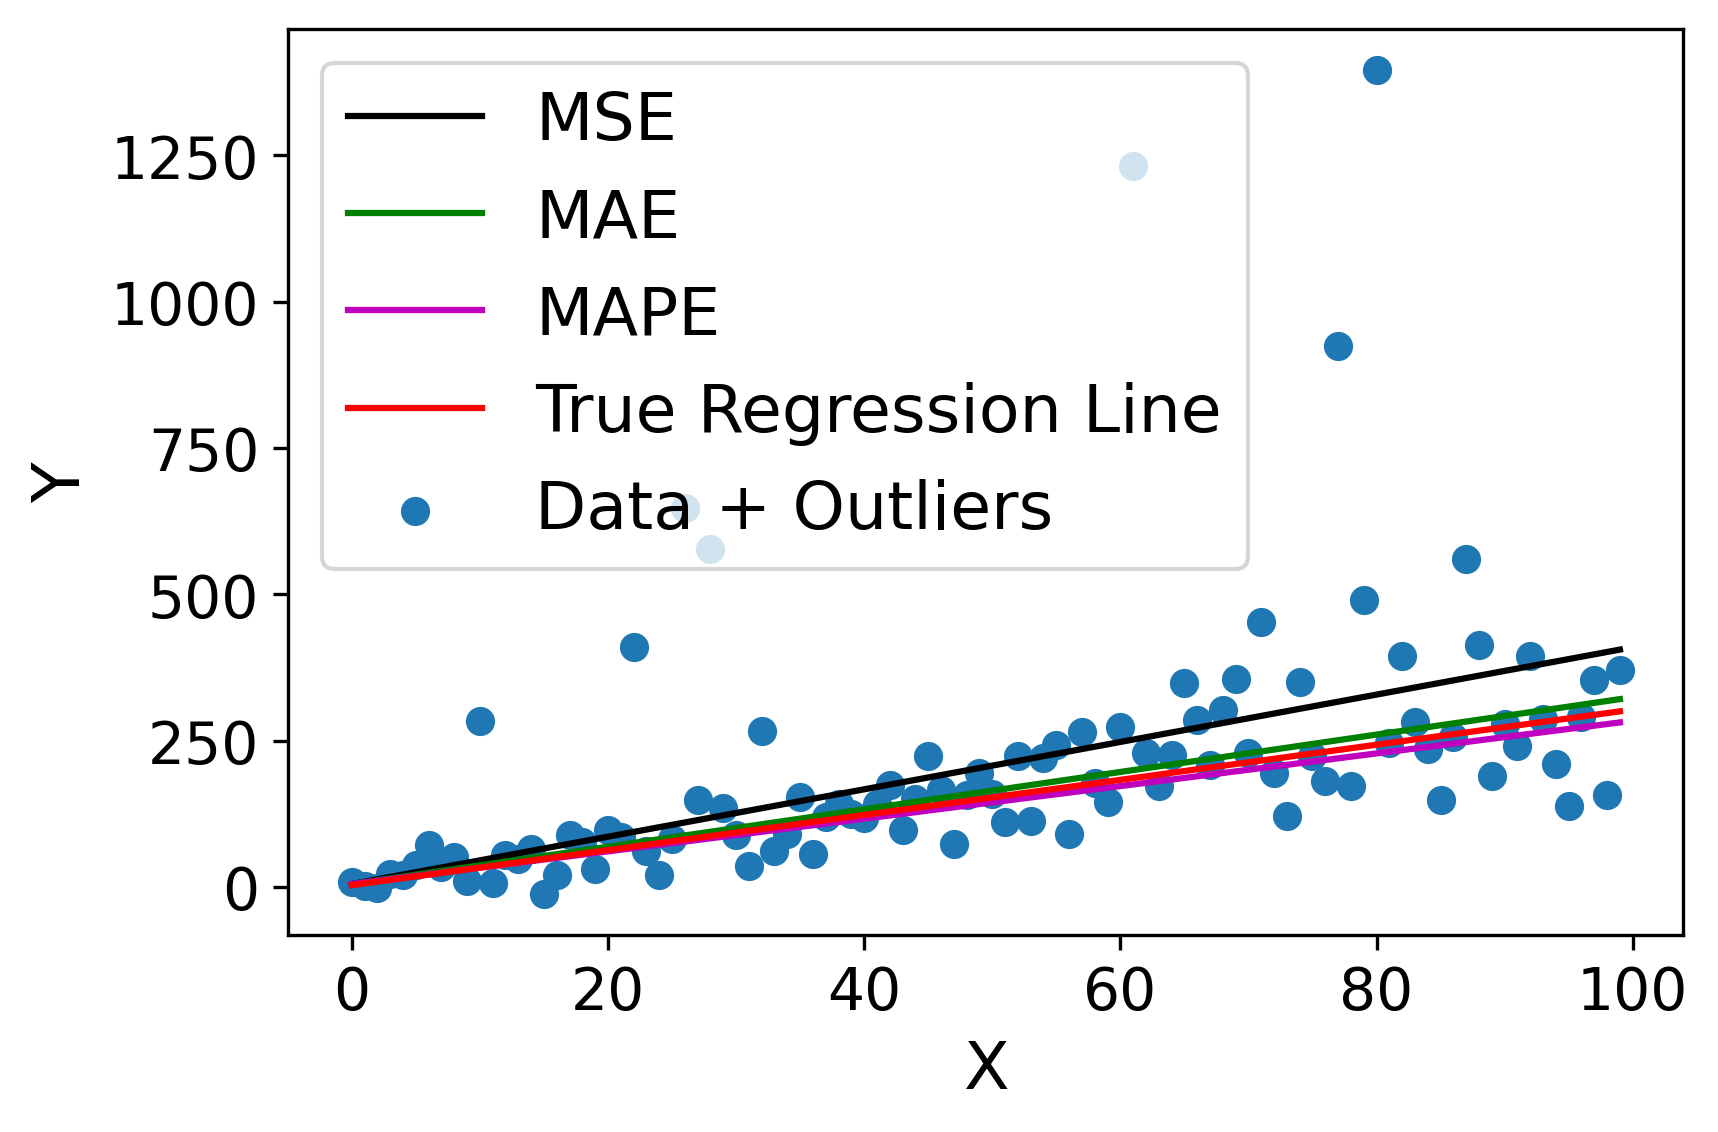

In [251]:
plt.scatter(x, poisson_outliers_data, label="Data + Outliers")
plt.plot(x, mse_slope * x + mse_intercept, c='k', label="MSE")
plt.plot(x, mae_slope * x + mae_intercept, c='g', label="MAE")
plt.plot(x, mape_slope * x + mape_intercept, c='m', label="MAPE")
plt.plot(x, 3 * x + 3, c='r', label="True Regression Line")
plt.legend(fontsize=14)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

While all close to the true regression line, each of the functions have distinct differences due to the nuances of how they work. The MSE function has the greatest slope, which is to be expected since it more susceptible to outliers. MAE and MAPE on the other hand hold up pretty well against the outliers. MAE and MAPE are very similar; however the MAPE function gets normalized by the true value.

In [252]:
x_lin = np.linspace(0, 1, 100)
x_log = np.logspace(2, 3, num=100)
xb = np.vstack((x,x_lin,x_log)).T

poly = PolynomialFeatures(2, include_bias=False)
new_xb = poly.fit_transform(xb)

In [253]:
ridge_model = RidgeCV(alphas=np.logspace(-5, 3, 13), normalize=True, cv=KFold(n_splits=10, shuffle=True, random_state=1), scoring='neg_mean_squared_error')

ridge_model.fit(new_xb, poisson_outliers_data)

ridge_coef =  np.hstack([ridge_model.coef_, ridge_model.intercept_])

print("Lowest MSE Alpha: ", ridge_model.alpha_)

Lowest MSE Alpha:  0.021544346900318822


In [254]:
lasso_model = Lasso(alpha = ridge_model.alpha_, max_iter = 1000000, tol = 0.005, normalize=True)

lasso_model.fit(new_xb, poisson_outliers_data)

lasso_coef = np.hstack([lasso_model.coef_, lasso_model.intercept_])

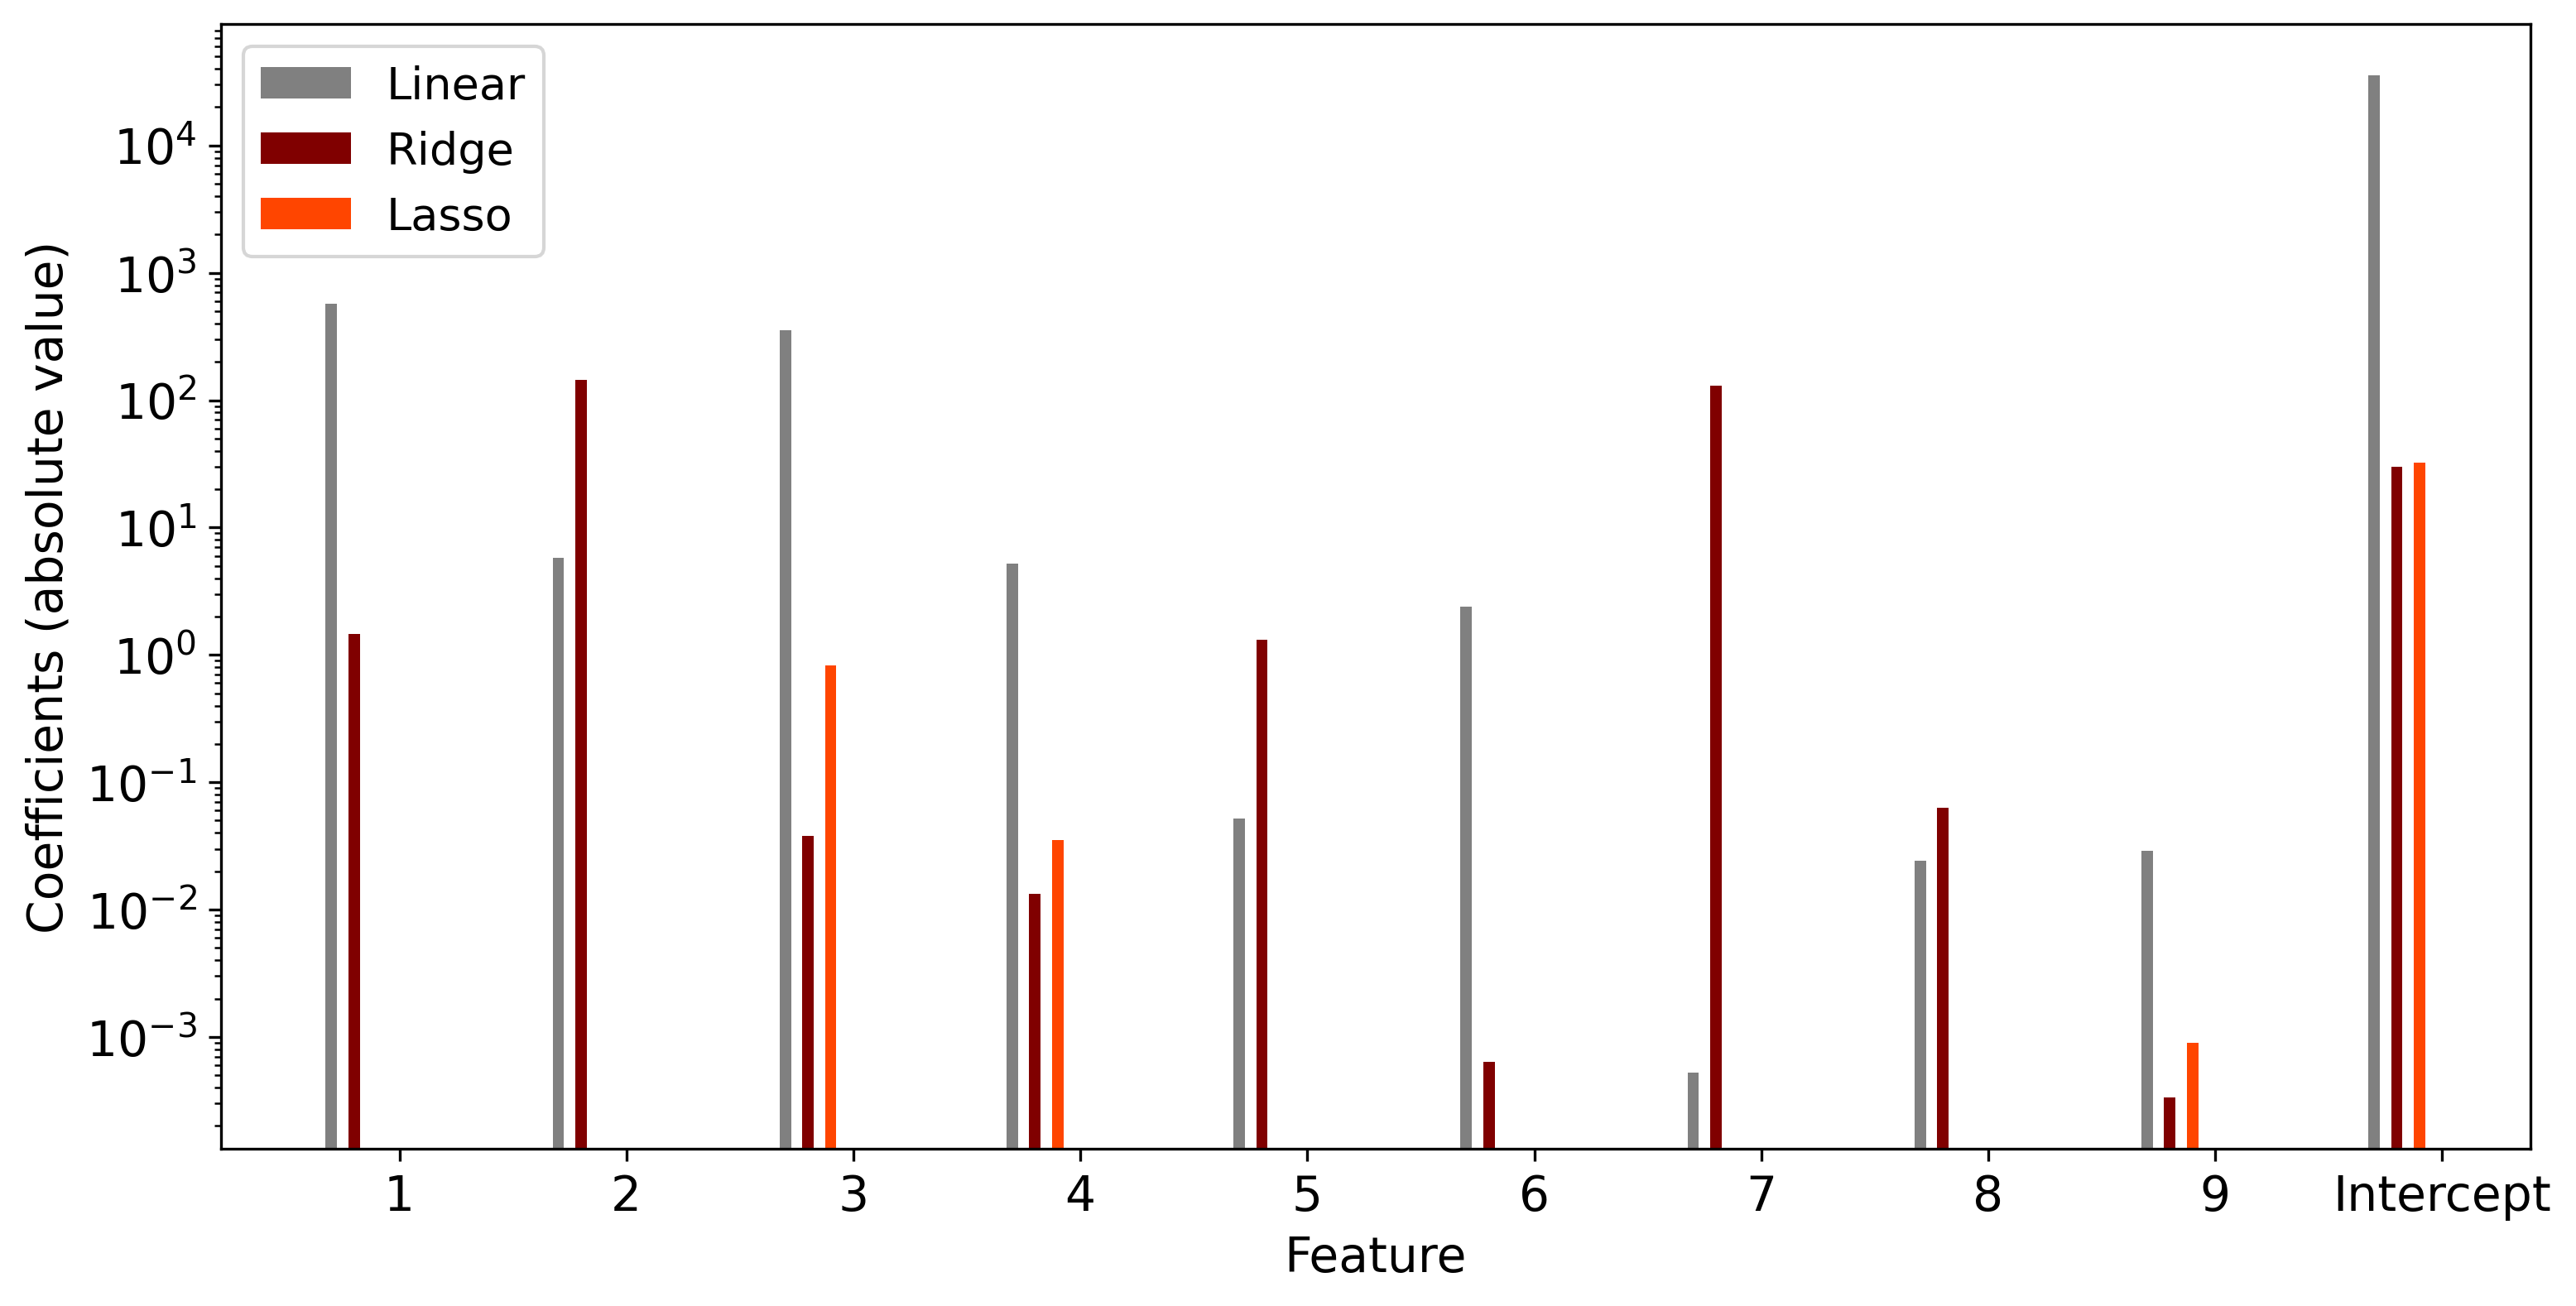

In [255]:
model = linear_model.LinearRegression()
model.fit(new_xb, poisson_outliers_data)
linear_coef = np.hstack([model.coef_, model.intercept_])

plt.figure(figsize=(12, 6))
plt.bar(np.arange(10) - 0.3, np.abs(linear_coef), color='grey', width=0.05, label='Linear')
plt.bar(np.arange(10) - 0.2, np.abs(ridge_coef), color='maroon', width=0.05, label='Ridge')
plt.bar(np.arange(10) - 0.1, np.abs(lasso_coef), color='orangered', width=0.05, label='Lasso')


plt.yscale('log')

plt.xticks(np.arange(10), ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'Intercept'])  # Set text labels.

plt.xlabel('Feature', fontsize=14)

plt.ylabel('Coefficients (absolute value)', fontsize=14)

plt.legend(fontsize=13);

With the lasso regression we see that values are actually going to zero; however, where coefficients exist they are constiantly greater than the value given by the ridge regression.